In [2698]:
########################################
# STEP 0: import libraries
########################################
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer 
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split
import sklearn.tree
import sklearn.ensemble
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder
import nltk
import pandas as pd
import sklearn.datasets
import sklearn.decomposition
import sklearn.discriminant_analysis
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.neighbors
import sklearn.preprocessing
import sklearn.random_projection
import sklearn.tree
import sklearn.svm
nltk.download('vader_lexicon') # Should print 3.9.1 or another recent version




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/avagrey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2699]:
###reading in initial###
df = pd.read_csv(("~/Downloads/train_data.csv"))
df.head(1)

,X,fullText,day,Harris,Trump,July,August,September,October,November,likes,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,0.000025,0.00001,0.000023,0.000019,0.020858,1,trump,indirect,negative


In [2700]:
########################################
# SUB-STEP: Prepare the dataset
########################################
analyzer = SentimentIntensityAnalyzer()

def get_vader_score(text):
    return analyzer.polarity_scores(text)['compound']

df['vader_score'] = df['fullText'].apply(get_vader_score)


def sentiment_match(vader_score, label):
    if vader_score > 0.05:
        vader_label = "positive"
    elif vader_score < -0.05:
        vader_label = "negative"
    else:
        vader_label = "neutral"  # Ensure consistency with manual labels

    return vader_label == label

df['vader_match'] = df.apply(lambda row: sentiment_match(row['vader_score'], row['Sentiment']), axis=1)

match_rate = df['vader_match'].mean()
print(f"VADER matches manual labels {match_rate*100:.2f}% of the time.")


df['Candidate'] = df['Candidate'].str.strip().str.lower()  # Remove spaces & lowercase
candidate_mapping = {'trump': 1, 'harris': 2, 'neither': 3}
df['Candidate'] = df['Candidate'].map(candidate_mapping)
df['Candidate'] = df['Candidate'].fillna(1).astype(int)
df.head(5)

VADER matches manual labels 45.80% of the time.


,X,fullText,day,Harris,Trump,July,August,September,October,November,...,retweets,views,comments,engagement_rate,id,Candidate,direction,Sentiment,vader_score,vader_match
0,6232,i think what people aren’t taking about enough...,14,0,1,0,1,0,0,0,...,0.000010,0.000023,0.000019,0.020858,1,1,indirect,negative,-0.4404,True
1,21769,i can’t believe trump is really launching a pr...,13,0,1,0,0,0,1,0,...,0.000052,0.000139,0.000889,0.035637,2,3,neutral,neutral,0.0000,True
2,20243,trump on the radio show sid & friends in the m...,7,0,1,0,0,0,1,0,...,0.000062,0.000054,0.000057,0.011930,3,1,indirect,negative,0.9423,False
3,16181,most of these trump supporting men are lonely ...,21,0,1,0,0,1,0,0,...,0.000010,0.000003,0.000019,0.117333,4,1,indirect,negative,-0.7003,True
4,4854,i think weve all confused jerry brown with wil...,9,0,1,0,1,0,0,0,...,0.000146,0.000071,0.000227,0.053209,5,3,neutral,neutral,0.0516,False


In [2701]:
########################################
# STEP 1: Process the dataset
########################################

df_model = df.drop(columns = ['vader_match', 'X', 'Harris', 'Trump'])

print(f"df_model.shape={df_model.shape}")

df_model.shape=(500, 17)


In [2702]:
########################################
# STEP 2: Apply data transformations
########################################
vectorizer = TfidfVectorizer(max_features=500)
X_model_tfidf = vectorizer.fit_transform(df_model['fullText'])

# Step 3: Convert to DataFrame
tfidf_train_df = pd.DataFrame(X_model_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Step 4: Remove 'fullText' and 'sentiment' before merging
df_model_features = df_model.drop(columns=['fullText', 'Candidate', 'Sentiment', 'direction', 'id'])

# Step 5: Ensure alignment by resetting index
x_train = pd.concat([tfidf_train_df.reset_index(drop=True), df_model_features.reset_index(drop=True)], axis=1)

# Step 6: Define Target Variable
y_train = df_model['Candidate'].reset_index(drop=True)

# Step 7: Verify Final Data
print("Final x_train shape:", x_train.shape)  # Should match (90, 1018) if 18 + 1000 features
print("Final y_train shape:", y_train.shape)
print(x_train.head())  # or print(df_train.head()) to check your dataset
print(y_train.head())

Final x_train shape: (500, 512)
Final y_train shape: (500,)
    10      2016  2020  2024  2025  abortion     about  absolutely  actually  \
0  0.0  0.269745   0.0   0.0   0.0       0.0  0.137932         0.0       0.0   
1  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   
2  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   
3  0.0  0.000000   0.0   0.0   0.0       0.0  0.157115         0.0       0.0   
4  0.0  0.000000   0.0   0.0   0.0       0.0  0.000000         0.0       0.0   

   administration  ...  August  September  October  November     likes  \
0             0.0  ...       1          0        0         0  0.000025   
1             0.0  ...       0          0        1         0  0.000208   
2             0.0  ...       0          0        1         0  0.000024   
3             0.0  ...       0          1        0         0  0.000021   
4             0.0  ...       1          0        0         0  0.000178   

   retweets   

In [2703]:
########################################
# STEP 3: Create train/test sets
########################################
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train  # Maintains class balance
)

# Further split training into train/validation
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.15, random_state=42, stratify=Y_train
)

# Print new distributions
print("New Training Class Distribution:\n", Y_train.value_counts(normalize=True))
print("\nNew Validation Class Distribution:\n", Y_val.value_counts(normalize=True))
print("\nNew Test Class Distribution:\n", Y_test.value_counts(normalize=True))

# Print final shapes
print(f"Training set: X_train={X_train.shape}, Y_train={Y_train.shape}")
print(f"Validation set: X_val={X_val.shape}, Y_val={Y_val.shape}")
print(f"Test set: X_test={X_test.shape}, Y_test={Y_test.shape}")


New Training Class Distribution:
 Candidate
1    0.438235
2    0.388235
3    0.173529
Name: proportion, dtype: float64

New Validation Class Distribution:
 Candidate
1    0.433333
2    0.400000
3    0.166667
Name: proportion, dtype: float64

New Test Class Distribution:
 Candidate
1    0.44
2    0.39
3    0.17
Name: proportion, dtype: float64
Training set: X_train=(340, 512), Y_train=(340,)
Validation set: X_val=(60, 512), Y_val=(60,)
Test set: X_test=(100, 512), Y_test=(100,)


In [2706]:
########################################
# STEP 5: Train a model
########################################

model_base = sklearn.tree.DecisionTreeClassifier(
   criterion='entropy',
   max_depth=2,
   min_samples_split=5,
   min_samples_leaf=30,
   max_features=None,
   max_leaf_nodes=5,
   random_state=42)
 
model = sklearn.ensemble.AdaBoostClassifier(
   estimator=model_base,
   n_estimators=50)



model.fit(X_train, Y_train)

# most of our discussions in class about "error"
# accuracy is just 1 - error

# report validation accuracy
validation_accuracy = model.score(X_val, Y_val)
print(f"validation_accuracy={validation_accuracy:0.4f}")
train_accuracy = model.score(X_train, Y_train)
print(f"train_accuracy={train_accuracy:0.4f}")


validation_accuracy=0.7333
train_accuracy=0.8559


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


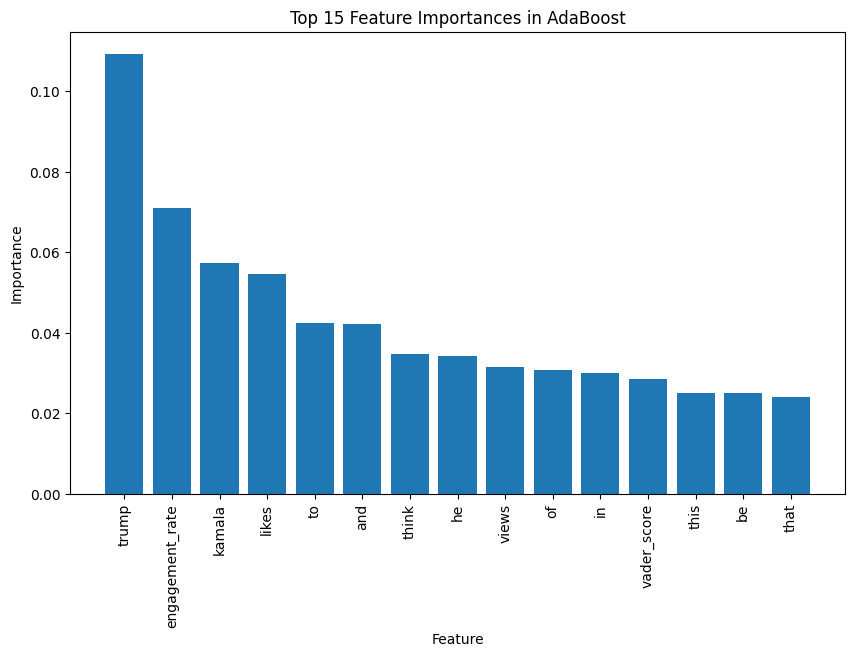

In [2707]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance from AdaBoost model
feature_importances = model.feature_importances_
feature_names = X_train.columns  # Get feature names

# Sort features by importance (descending order)
indices = np.argsort(feature_importances)[::-1]

# Select top 15 features
top_n = 15
top_indices = indices[:top_n]
top_features = np.array(feature_names)[top_indices]
top_importances = feature_importances[top_indices]

# Plot the top 15 features
plt.figure(figsize=(10, 6))
plt.title("Top 15 Feature Importances in AdaBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_features, rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.show()

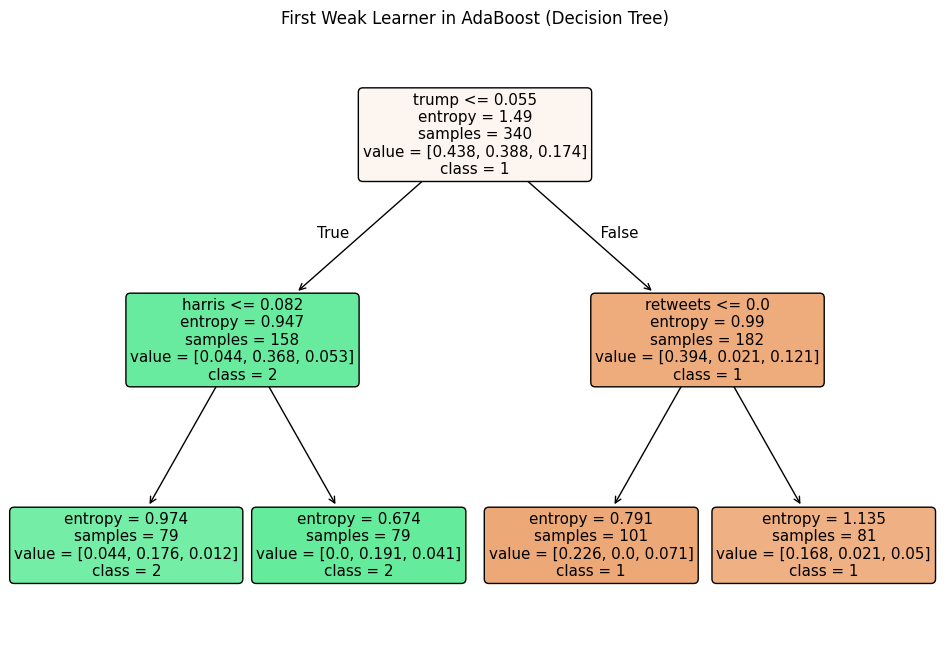

In [2708]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Get first weak learner (decision tree)
first_tree = model.estimators_[0]

# Dynamically extract class names from Y_train
class_labels = [str(label) for label in np.unique(Y_train)]

# Ensure it's a Decision Tree before plotting
if hasattr(first_tree, "tree_"):
    plt.figure(figsize=(12, 8))
    plot_tree(
        first_tree, 
        feature_names=X_train.columns, 
        class_names=class_labels,  # Use dynamically extracted class names
        filled=True, rounded=True
    )
    plt.title("First Weak Learner in AdaBoost (Decision Tree)")
    plt.show()
else:
    print("First weak learner is not a decision tree. Check AdaBoost configuration.")



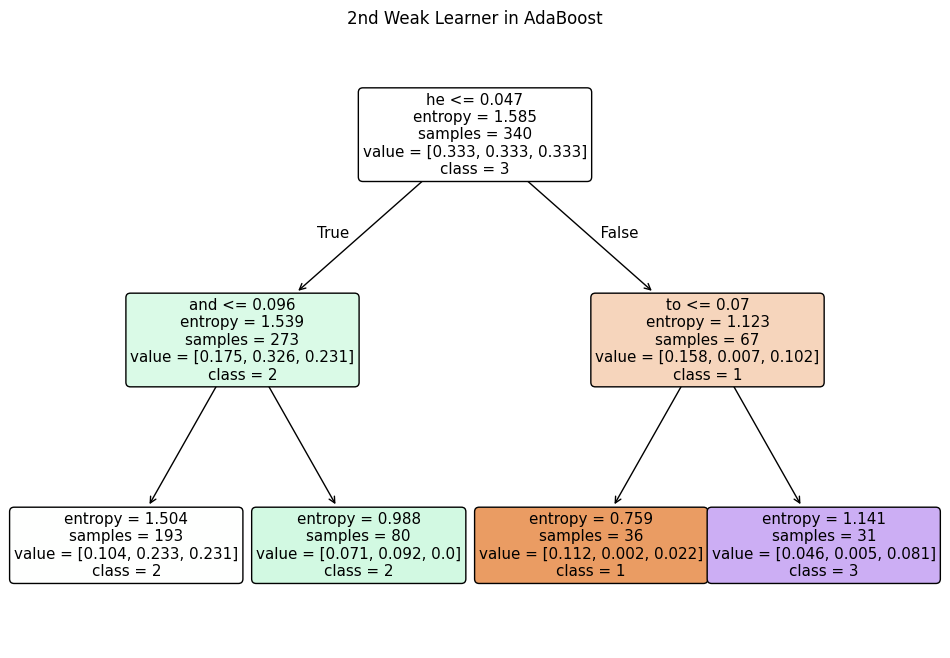

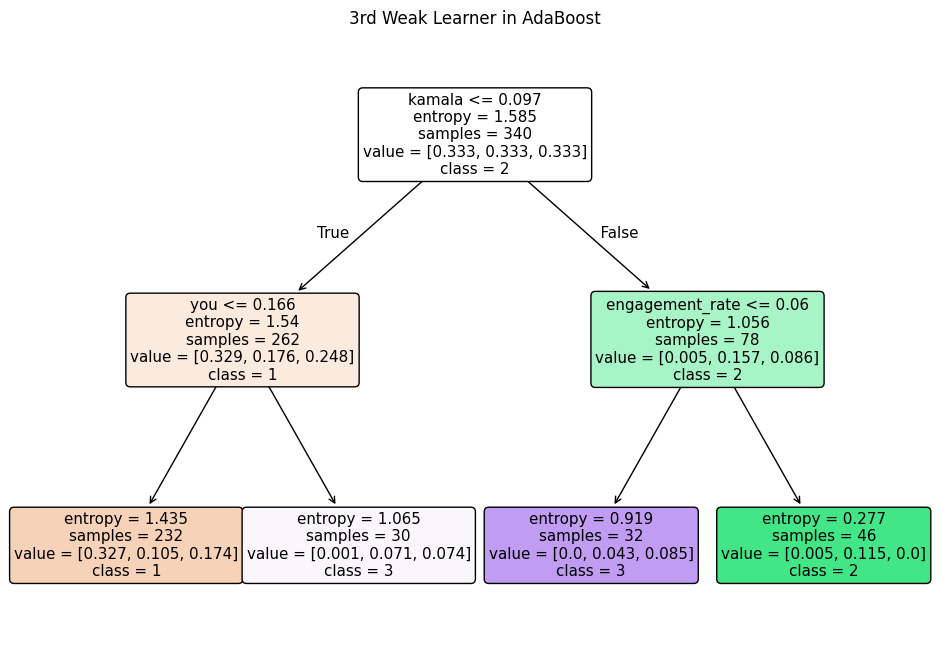

In [2709]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize the second weak learner (index 1)
plt.figure(figsize=(12, 8))
plot_tree(
    model.estimators_[1], 
    feature_names=x_train.columns,  # or vectorizer.get_feature_names_out()
    class_names=[str(c) for c in model.classes_],
    filled=True, rounded=True
)
plt.title("2nd Weak Learner in AdaBoost")
plt.show()

# Visualize the 10th weak learner (index 9)
plt.figure(figsize=(12, 8))
plot_tree(
    model.estimators_[2], 
    feature_names=x_train.columns,
    class_names=[str(c) for c in model.classes_],
    filled=True, rounded=True
)
plt.title("3rd Weak Learner in AdaBoost")
plt.show()



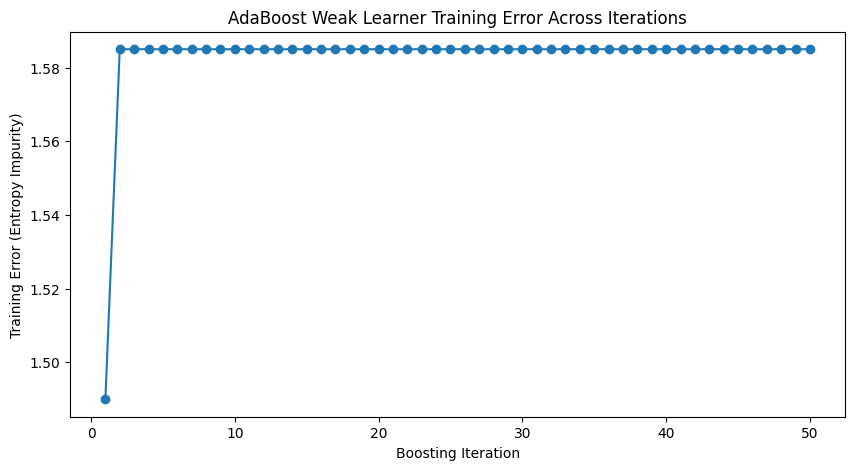

In [2710]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the training errors from each weak learner
errors = np.array([estimator.tree_.impurity[0] for estimator in model.estimators_])

# Plot training error across boosting iterations
plt.figure(figsize=(10,5))
plt.plot(range(1, len(errors)+1), errors, marker='o', linestyle='-')
plt.xlabel("Boosting Iteration")
plt.ylabel("Training Error (Entropy Impurity)")
plt.title("AdaBoost Weak Learner Training Error Across Iterations")
plt.show()



In [2711]:
# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 3 to others
candidate_3_diff = feature_means_by_candidate.loc[3] - feature_means_by_candidate.loc[[1, 2]].mean()

# Show top differences
print(candidate_3_diff.sort_values(ascending=False).head(20))

day              0.135411
August           0.032582
on               0.027015
July             0.025607
November         0.023570
trump            0.022462
as               0.019205
do               0.017838
assassination    0.016664
yall             0.016628
crazy            0.016608
president        0.016207
million          0.015585
with             0.014301
about            0.013605
after            0.013430
chris            0.013303
believe          0.013225
should           0.013191
victory          0.013084
dtype: float64


In [2712]:
import pandas as pd

# Compute mean feature values for each candidate
feature_means_by_candidate = X_train.groupby(Y_train).mean()

# Compare Candidate 2 to Candidate 1
candidate_2_vs_1 = feature_means_by_candidate.loc[2] - feature_means_by_candidate.loc[1]
candidate_2_vs_1_sorted = candidate_2_vs_1.sort_values(ascending=False)

# Compare Candidate 1 to Candidate 2
candidate_1_vs_2 = feature_means_by_candidate.loc[1] - feature_means_by_candidate.loc[2]
candidate_1_vs_2_sorted = candidate_1_vs_2.sort_values(ascending=False)

# Convert to DataFrames for better readability
candidate_2_vs_1_df = candidate_2_vs_1_sorted.to_frame()
candidate_2_vs_1_df.columns = ["Difference (Candidate 2 - Candidate 1)"]

candidate_1_vs_2_df = candidate_1_vs_2_sorted.to_frame()
candidate_1_vs_2_df.columns = ["Difference (Candidate 1 - Candidate 2)"]

# Display the top 20 distinctive features for each comparison
print("🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:")
print(candidate_2_vs_1_df.head(20))

print("\n🔹 Features that appear more in Candidate 1's tweets than Candidate 2's:")
print(candidate_1_vs_2_df.head(20))

#overall trend (similar to direction) harris has more indirect related tweets while trump is more direct 
# for exmaple, harris as a lot of identifiers with biden, or walz while trump has win, election, etc

🔹 Features that appear more in Candidate 2's tweets than Candidate 1's:
             Difference (Candidate 2 - Candidate 1)
day                                        1.268253
vader_score                                0.145468
kamala                                     0.089828
harris                                     0.076737
July                                       0.044794
she                                        0.039659
her                                        0.038117
October                                    0.022015
biden                                      0.019602
be                                         0.018070
for                                        0.017628
but                                        0.017085
September                                  0.016829
anyone                                     0.014561
from                                       0.013841
than                                       0.013188
you                                        0

In [2713]:
########################################
# STEP 6: Evaluate on test set
########################################

# WARNING:
# this code should be run only once;
# after the hyperparameters have been decided based on the validation performance,
# then the False can be changed to True to run this code
if True:
    model.fit(X_train, Y_train)
    test_accuracy = model.score(X_test, Y_test)
    print(f"test_accuracy={test_accuracy}")

    y_test_pred = model.predict(X_test)

    # Compute test set metrics
    print("Test Set Metrics:")
    print(classification_report(Y_test, y_test_pred))

test_accuracy=0.77
Test Set Metrics:
              precision    recall  f1-score   support

           1       0.76      0.89      0.82        44
           2       0.86      0.92      0.89        39
           3       0.29      0.12      0.17        17

    accuracy                           0.77       100
   macro avg       0.64      0.64      0.63       100
weighted avg       0.72      0.77      0.74       100



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


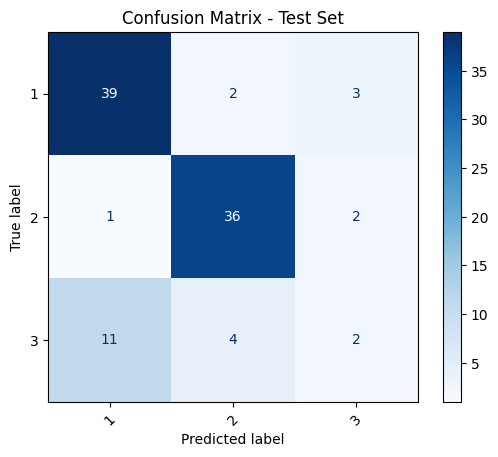

In [2714]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Test Set")
plt.show()

In [2715]:
###
#add predictions to new data set to use to train either direction or candidate
###
y_all_pred = model.predict(x_train)

df_model2 = df_model.reset_index(drop=True)  # Ensure alignment
df_model2['candidate_pred'] = y_all_pred

df_model2.shape[0]
df_model2 = df_model2[["fullText", "Candidate", "candidate_pred"]]

accuracy = (df_model2['Candidate'] == df_model2['candidate_pred']).mean()
print(f"Overall accuracy on full 500 samples: {accuracy:.4f}")

df_mistakes = df_model2[df_model['Candidate'] != df_model2['candidate_pred']]
print(df_mistakes[['fullText', 'Candidate', 'candidate_pred']].head(10))




Overall accuracy on full 500 samples: 0.8240
                                             fullText  Candidate  \
0   i think what people aren’t taking about enough...          1   
4   i think weve all confused jerry brown with wil...          3   
9   i believe it’s time to start making purchases ...          3   
14  to me, acquiescing is the worst move, but it s...          1   
29  how do yall feel about trumps proposal to abol...          3   
32  so republicans are mad bc they (falsely) belie...          3   
35  let me get this straight: democrats lied to th...          3   
36  do you believe trump will return to x in the n...          3   
38  anyone who has voted for or will vote for dona...          1   
44  us political class wants us to believe ✌️unity...          3   

    candidate_pred  
0                3  
4                1  
9                1  
14               3  
29               2  
32               2  
35               2  
36               1  
38               